In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from c_Population_graph.community_detection import detect_communities
from survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

### Parameters

In [8]:
iteration = 3
PhenoGraph_k =  30
size_smallest_cluster = 20
survival_type = 'Overall'
PopulationGraph_type = 'complete_graph_with_weak_edges_removed'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k':15
}

### Load Kernel martrix and clincial data

In [9]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Disease-specific Survival Status'] = clinical['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})


### Community Detection

In [10]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)
Community_ids = detect_communities(G_population, size_smallest_cluster)

### Calculate hazard

In [11]:
if survival_type == 'Overall':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]  
elif survival_type == 'Relpase-free':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs] 
elif survival_type == 'Disease-specific':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
for i in range(len(HR)):
    print("Community {}:".format(HR[i]['community_id']))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))

Community 1.0:
Survival: hr = 0.5647635341126868, p = 0.0024713023536664528
Community 2.0:
Survival: hr = 0.6920970107910603, p = 0.08802851601715121
Community 3.0:
Survival: hr = 0.926438445270948, p = 0.7147524528189434
Community 4.0:
Survival: hr = 1.2599083317740505, p = 0.32050719861178134
Community 5.0:
Survival: hr = 1.3754735645853247, p = 0.2527850950893764
Community 6.0:
Survival: hr = 1.3504465156105545, p = 0.26571887687299334
Community 7.0:
Survival: hr = 1.814144838028933, p = 0.028006453645078963
Community 8.0:
Survival: hr = 1.9941462059893302, p = 0.013790426565128123
Community 9.0:
Survival: hr = 1.6675700998860676, p = 0.08745518617186658


### Reorder Communities based on Hazard

In [12]:
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]["community_id"]] = i + 1
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{}:".format(HR[i]['subgroup_id']))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))

S1:
Survival: hr = 1.9941462059893302, p = 0.013790426565128123
S2:
Survival: hr = 1.814144838028933, p = 0.028006453645078963
S3:
Survival: hr = 1.6675700998860676, p = 0.08745518617186658
S4:
Survival: hr = 1.3754735645853247, p = 0.2527850950893764
S5:
Survival: hr = 1.3504465156105545, p = 0.26571887687299334
S6:
Survival: hr = 1.2599083317740505, p = 0.32050719861178134
S7:
Survival: hr = 0.926438445270948, p = 0.7147524528189434
S8:
Survival: hr = 0.6920970107910603, p = 0.08802851601715121
S9:
Survival: hr = 0.5647635341126868, p = 0.0024713023536664528


### Plot population graph painted with patient subgroup ids

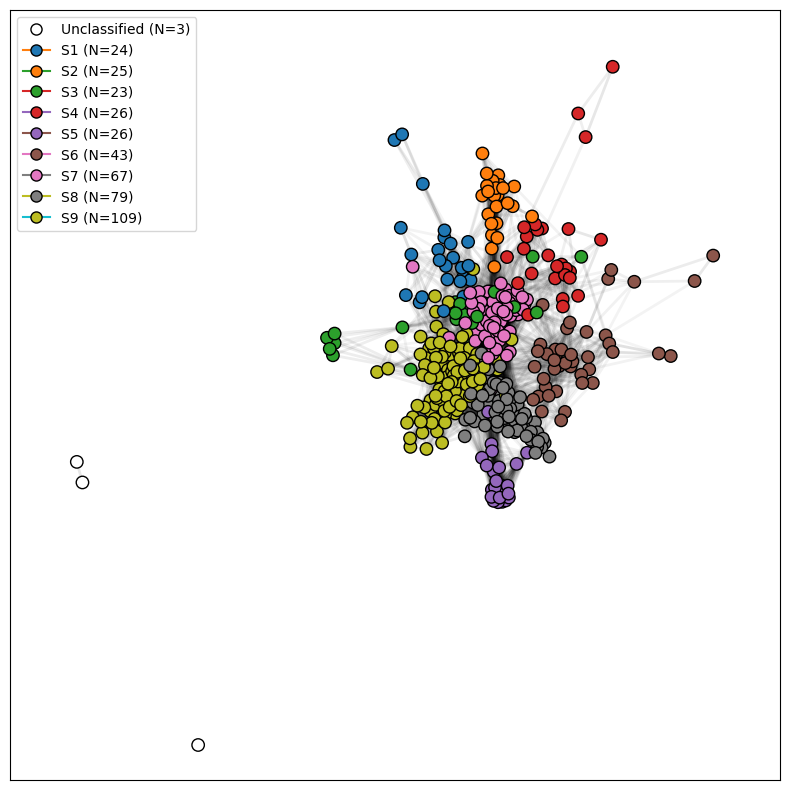

In [13]:
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids], 
            edgecolors="black"
        )
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[0],
        label=f"Unclassified (N={np.sum(Subgroup_ids == 0)})",
        markerfacecolor=color_palette[0],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
]
for i in range(1, len(np.unique(Subgroup_ids))):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[i + 1],
        label=f"S{i} (N={np.sum(Subgroup_ids == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles)
plt.show()

### Plot hazard

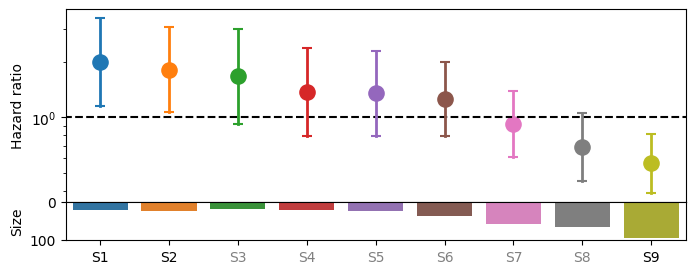

In [14]:
# Plot hazard ratio
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

### Plot K-M survival curves

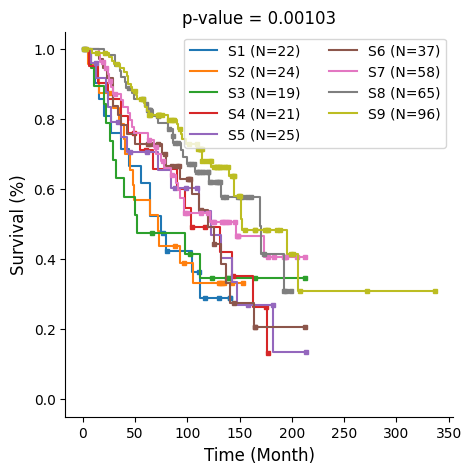

In [15]:

kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Individual K-M plot for eaach subgroup

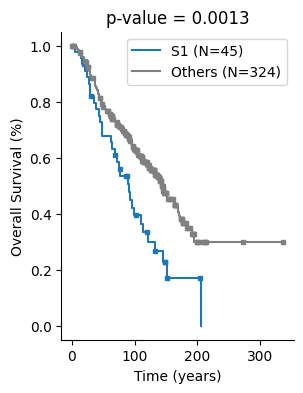

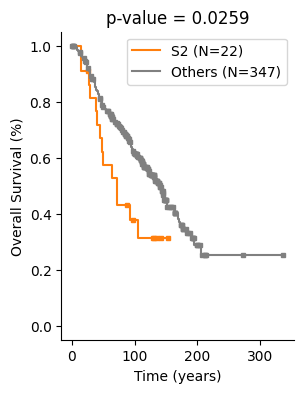

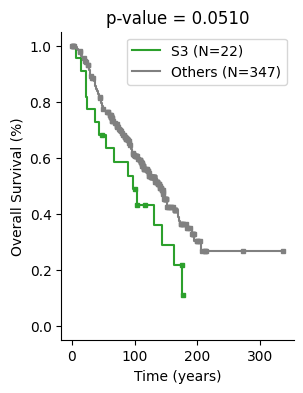

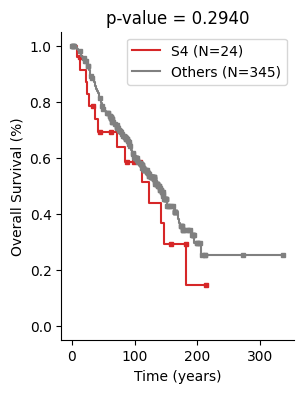

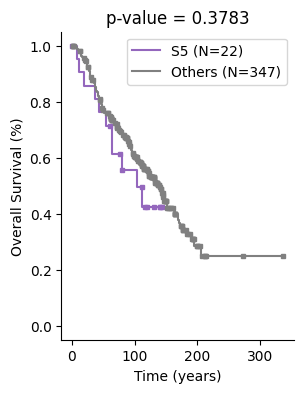

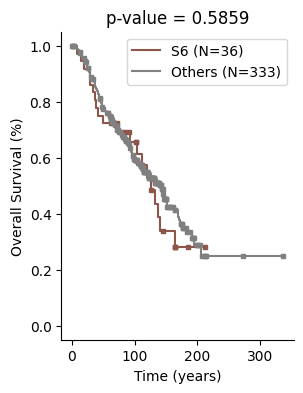

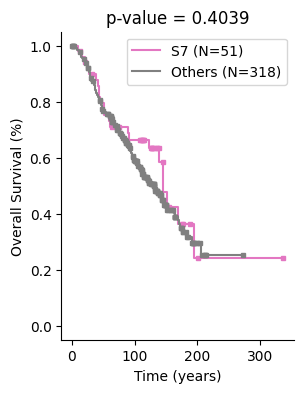

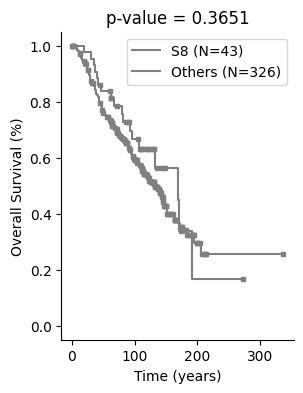

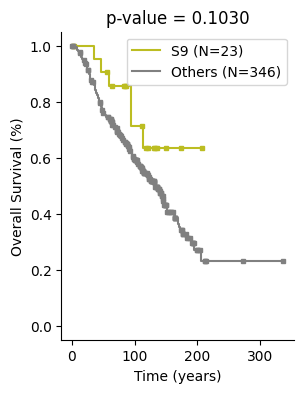

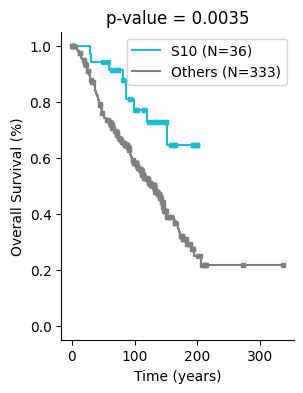

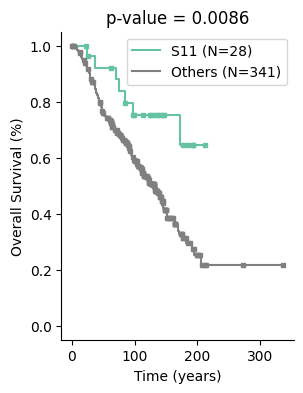

In [10]:
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    f, ax = plt.subplots(figsize=(3, 4))
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    length_B, event_observed_B = (
            Length_[Subgroup_ids_ != subgroup_id],
            Status_[Subgroup_ids_ != subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], len(length_A))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})
    label = "Others (N={})".format(len(length_B))
    kmf.fit(length_B, event_observed_B, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color="grey",
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})
    log_rank_test = logrank_test(length_A, length_B, event_observed_A, event_observed_B)
    p_value = log_rank_test.p_value
    ax.legend()
    ax.set(
            title="p-value = {:.4f}".format(p_value),
            # title="Survival of {} vs. Others".format(hr_dict["subgroup_id"]),
            xlabel="Time (years)",
            ylabel=survival_type+" Survival (%)",
            ylim=(-0.05, 1.05),
        )
    sns.despine()
    plt.show()